# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras
import itertools

# Disable GPU，若有 GPU 且想開啟，可設為 "0"，不需使用 GPU, 將 GPU 設定為 ""
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
# 用 Keras 來構建一個分類神經網絡，用到的數據集是 MNIST，就是 0 到 9 這幾個數字的圖片數據集。
# 從 Keras 的內建功能中，取得 cifar10 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理 - 標準化
# 因為每個像素都是在 0 到 255 之間的，標準化之後就變成了 0 到 1 之間。
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
# X 是一張張圖片，Y 是每張圖片對應的標籤，即它是哪個數字。
# 將 X 與 Y 獨立放進變數
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化，在上一個區塊已經定義了preproc_x的功能
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot，在上一個區塊已經定義了preproc_y的功能
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
"""
建立神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 128, 256, 128, 64]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 128)               16512     
_________________________________________________________________
hidden_layer5 (Dense)        (None, 256)               33024     
_________________________________________________________________
hidden_layer6 (Dense)        (None, 128)               3289

In [7]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
OPTIMIZER = [keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adagrad, keras.optimizers.Adam]

In [8]:
"""
建立你的訓練與實驗迴圈並蒐集資料
"""

results = {}
for lr, opti in itertools.product(LEARNING_RATE, OPTIMIZER):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f, Optimizer = %s" % (lr, str(opti)))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    optimizer = opti(lr=lr)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s-optimizer-%s" % (str(lr), str(opti))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}

Experiment with LR = 0.100000, Optimizer = <class 'keras.optimizers.SGD'>
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 128)               16512     
_________________________________________________________________
hidden_layer5 (Dense)        (None, 256)               33024     
___________________________________________________

Epoch 45/50
50000/50000 [==============================] - 7s 132us/step - loss: 0.9226 - accuracy: 0.6702 - val_loss: 1.7422 - val_accuracy: 0.4461
Epoch 46/50
50000/50000 [==============================] - 6s 129us/step - loss: 0.9000 - accuracy: 0.6784 - val_loss: 1.5740 - val_accuracy: 0.4911
Epoch 47/50
50000/50000 [==============================] - 6s 129us/step - loss: 0.8882 - accuracy: 0.6842 - val_loss: 2.0668 - val_accuracy: 0.4213
Epoch 48/50
50000/50000 [==============================] - 6s 125us/step - loss: 0.8880 - accuracy: 0.6837 - val_loss: 1.7167 - val_accuracy: 0.4850
Epoch 49/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.8571 - accuracy: 0.6951 - val_loss: 1.6940 - val_accuracy: 0.4668
Epoch 50/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.8422 - accuracy: 0.7005 - val_loss: 1.6936 - val_accuracy: 0.4872
Experiment with LR = 0.100000, Optimizer = <class 'keras.optimizers.RMSprop'>
Model: "model_1"
___________

Epoch 39/50
50000/50000 [==============================] - 8s 166us/step - loss: 2.3073 - accuracy: 0.1023 - val_loss: 2.3102 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.3081 - accuracy: 0.0996 - val_loss: 2.3120 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 8s 167us/step - loss: 2.3080 - accuracy: 0.0973 - val_loss: 2.3155 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.3076 - accuracy: 0.1005 - val_loss: 2.3132 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 9s 170us/step - loss: 2.3082 - accuracy: 0.0994 - val_loss: 2.3082 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 8s 163us/step - loss: 2.3083 - accuracy: 0.0992 - val_loss: 2.3103 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.3081 - accuracy: 0.0983

Epoch 33/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.9701 - accuracy: 0.2440 - val_loss: 1.9612 - val_accuracy: 0.2491
Epoch 34/50
50000/50000 [==============================] - 7s 150us/step - loss: 1.9657 - accuracy: 0.2450 - val_loss: 1.9583 - val_accuracy: 0.2497
Epoch 35/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.9639 - accuracy: 0.2455 - val_loss: 1.9644 - val_accuracy: 0.2501
Epoch 36/50
50000/50000 [==============================] - 7s 148us/step - loss: 1.9603 - accuracy: 0.2465 - val_loss: 1.9635 - val_accuracy: 0.2447
Epoch 37/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.9590 - accuracy: 0.2478 - val_loss: 1.9891 - val_accuracy: 0.2358
Epoch 38/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.9560 - accuracy: 0.2476 - val_loss: 1.9467 - val_accuracy: 0.2530
Epoch 39/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.9552 - accuracy: 0.2501

50000/50000 [==============================] - 11s 226us/step - loss: 2.3063 - accuracy: 0.1005 - val_loss: 2.3065 - val_accuracy: 0.1000
Epoch 27/50
50000/50000 [==============================] - 10s 205us/step - loss: 2.3065 - accuracy: 0.1006 - val_loss: 2.3054 - val_accuracy: 0.1000
Epoch 28/50
50000/50000 [==============================] - 11s 215us/step - loss: 2.3063 - accuracy: 0.1004 - val_loss: 2.3073 - val_accuracy: 0.1000
Epoch 29/50
50000/50000 [==============================] - 11s 219us/step - loss: 2.3066 - accuracy: 0.1002 - val_loss: 2.3042 - val_accuracy: 0.1000
Epoch 30/50
50000/50000 [==============================] - 11s 210us/step - loss: 2.3067 - accuracy: 0.1000 - val_loss: 2.3121 - val_accuracy: 0.1000
Epoch 31/50
50000/50000 [==============================] - 11s 222us/step - loss: 2.3068 - accuracy: 0.0981 - val_loss: 2.3048 - val_accuracy: 0.1000
Epoch 32/50
50000/50000 [==============================] - 11s 214us/step - loss: 2.3068 - accuracy: 0.1019 - va

50000/50000 [==============================] - 6s 128us/step - loss: 1.4961 - accuracy: 0.4660 - val_loss: 1.5007 - val_accuracy: 0.4644
Epoch 20/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.4798 - accuracy: 0.4727 - val_loss: 1.5122 - val_accuracy: 0.4577
Epoch 21/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.4700 - accuracy: 0.4773 - val_loss: 1.5122 - val_accuracy: 0.4588
Epoch 22/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.4548 - accuracy: 0.4809 - val_loss: 1.5049 - val_accuracy: 0.4585
Epoch 23/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.4369 - accuracy: 0.4895 - val_loss: 1.5105 - val_accuracy: 0.4636
Epoch 24/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.4368 - accuracy: 0.4902 - val_loss: 1.6249 - val_accuracy: 0.4234
Epoch 25/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.4145 - accuracy: 0.4950 - val_loss:

Epoch 13/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.8629 - accuracy: 0.3119 - val_loss: 1.8052 - val_accuracy: 0.3199
Epoch 14/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.8450 - accuracy: 0.3212 - val_loss: 1.8490 - val_accuracy: 0.3220
Epoch 15/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.8325 - accuracy: 0.3280 - val_loss: 2.0181 - val_accuracy: 0.2816
Epoch 16/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.8390 - accuracy: 0.3245 - val_loss: 1.8504 - val_accuracy: 0.3078
Epoch 17/50
50000/50000 [==============================] - 8s 170us/step - loss: 1.8265 - accuracy: 0.3312 - val_loss: 1.8813 - val_accuracy: 0.2940
Epoch 18/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.8218 - accuracy: 0.3338 - val_loss: 1.8836 - val_accuracy: 0.3105
Epoch 19/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.8160 - accuracy: 0.3383

Epoch 7/50
50000/50000 [==============================] - 8s 150us/step - loss: 1.6307 - accuracy: 0.4146 - val_loss: 1.7799 - val_accuracy: 0.3614
Epoch 8/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.5904 - accuracy: 0.4316 - val_loss: 1.6733 - val_accuracy: 0.4016
Epoch 9/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.5612 - accuracy: 0.4406 - val_loss: 1.5889 - val_accuracy: 0.4303
Epoch 10/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.5297 - accuracy: 0.4518 - val_loss: 1.5300 - val_accuracy: 0.4527
Epoch 11/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.4974 - accuracy: 0.4631 - val_loss: 1.6313 - val_accuracy: 0.4286
Epoch 12/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.4756 - accuracy: 0.4700 - val_loss: 1.5707 - val_accuracy: 0.4450
Epoch 13/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.4534 - accuracy: 0.4788 - 

50000/50000 [==============================] - 10s 205us/step - loss: 2.3741 - accuracy: 0.1526 - val_loss: 2.0419 - val_accuracy: 0.2057
Epoch 2/50
50000/50000 [==============================] - 11s 216us/step - loss: 1.9772 - accuracy: 0.2477 - val_loss: 1.8958 - val_accuracy: 0.2810
Epoch 3/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.8813 - accuracy: 0.2877 - val_loss: 1.8853 - val_accuracy: 0.2981
Epoch 4/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.8358 - accuracy: 0.3072 - val_loss: 1.8426 - val_accuracy: 0.3008
Epoch 5/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.8092 - accuracy: 0.3210 - val_loss: 1.7730 - val_accuracy: 0.3407
Epoch 6/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.7685 - accuracy: 0.3388 - val_loss: 1.8349 - val_accuracy: 0.3351
Epoch 7/50
50000/50000 [==============================] - 10s 208us/step - loss: 1.7577 - accuracy: 0.3501 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 127us/step - loss: 2.3057 - accuracy: 0.1027 - val_loss: 2.2983 - val_accuracy: 0.1211
Epoch 2/50
50000/50000 [==============================] - 6s 126us/step - loss: 2.2942 - accuracy: 0.1297 - val_loss: 2.2902 - val_accuracy: 0.1413
Epoch 3/50
50000/50000 [==============================] - 6s 124us/step - loss: 2.2864 - accuracy: 0.1416 - val_loss: 2.2824 - val_accuracy: 0.1463
Epoch 4/50
50000/50000 [==============================] - 6s 127us/step - loss: 2.2781 - accuracy: 0.1459 - val_loss: 2.2741 - val_accuracy: 0.1474
Epoch 5/50
50000/50000 [==============================] - 6s 124us/step - loss: 2.2692 - accuracy: 0.1509 - val_loss: 2.2648 - val_accuracy: 0.1500
Epoch 6/50
50000/50000 [==============================] - 6s 124us/step - loss: 2.2592 - accuracy: 0.1588 - val_loss: 2.2542 - val_accuracy: 0.1604
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 173us/step - loss: 2.1771 - accuracy: 0.1769 - val_loss: 2.0498 - val_accuracy: 0.2223
Epoch 2/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.9543 - accuracy: 0.2850 - val_loss: 1.8893 - val_accuracy: 0.3135
Epoch 3/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.8639 - accuracy: 0.3265 - val_loss: 1.8125 - val_accuracy: 0.3393
Epoch 4/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.7905 - accuracy: 0.3555 - val_loss: 1.9131 - val_accuracy: 0.3002
Epoch 5/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.7383 - accuracy: 0.3764 - val_loss: 1.7821 - val_accuracy: 0.3547
Epoch 6/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.6926 - accuracy: 0.3921 - val_loss: 1.7094 - val_accuracy: 0.3872
Epoch 7/50
50000/50000 [==============================] - 9s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 156us/step - loss: 2.0555 - accuracy: 0.2430 - val_loss: 1.8889 - val_accuracy: 0.3139
Epoch 2/50
50000/50000 [==============================] - 7s 148us/step - loss: 1.8505 - accuracy: 0.3362 - val_loss: 1.8138 - val_accuracy: 0.3340
Epoch 3/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.7632 - accuracy: 0.3661 - val_loss: 1.7478 - val_accuracy: 0.3673
Epoch 4/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.7065 - accuracy: 0.3895 - val_loss: 1.7181 - val_accuracy: 0.3650
Epoch 5/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.6695 - accuracy: 0.4012 - val_loss: 1.6509 - val_accuracy: 0.4093
Epoch 6/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.6383 - accuracy: 0.4148 - val_loss: 1.7102 - val_accuracy: 0.3873
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 202us/step - loss: 1.9840 - accuracy: 0.2624 - val_loss: 1.8062 - val_accuracy: 0.3433
Epoch 2/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.7468 - accuracy: 0.3653 - val_loss: 1.7032 - val_accuracy: 0.3927
Epoch 3/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.6648 - accuracy: 0.4004 - val_loss: 1.6074 - val_accuracy: 0.4243
Epoch 4/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.6055 - accuracy: 0.4227 - val_loss: 1.5854 - val_accuracy: 0.4259
Epoch 5/50
50000/50000 [==============================] - 10s 201us/step - loss: 1.5462 - accuracy: 0.4437 - val_loss: 1.5169 - val_accuracy: 0.4547
Epoch 6/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.5006 - accuracy: 0.4627 - val_loss: 1.5426 - val_accuracy: 0.4433
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 128us/step - loss: 2.3080 - accuracy: 0.0990 - val_loss: 2.3069 - val_accuracy: 0.0988
Epoch 2/50
50000/50000 [==============================] - 6s 124us/step - loss: 2.3065 - accuracy: 0.0989 - val_loss: 2.3054 - val_accuracy: 0.0991
Epoch 3/50
50000/50000 [==============================] - 6s 125us/step - loss: 2.3051 - accuracy: 0.0990 - val_loss: 2.3040 - val_accuracy: 0.0993
Epoch 4/50
50000/50000 [==============================] - 6s 126us/step - loss: 2.3038 - accuracy: 0.0987 - val_loss: 2.3028 - val_accuracy: 0.0998
Epoch 5/50
50000/50000 [==============================] - 6s 123us/step - loss: 2.3026 - accuracy: 0.0993 - val_loss: 2.3016 - val_accuracy: 0.1013
Epoch 6/50
50000/50000 [==============================] - 6s 127us/step - loss: 2.3016 - accuracy: 0.1005 - val_loss: 2.3006 - val_accuracy: 0.1025
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.0344 - accuracy: 0.2552 - val_loss: 1.9425 - val_accuracy: 0.2835
Epoch 2/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.8628 - accuracy: 0.3300 - val_loss: 1.8277 - val_accuracy: 0.3361
Epoch 3/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.7774 - accuracy: 0.3631 - val_loss: 1.7485 - val_accuracy: 0.3732
Epoch 4/50
50000/50000 [==============================] - 8s 170us/step - loss: 1.7138 - accuracy: 0.3867 - val_loss: 1.6801 - val_accuracy: 0.3962
Epoch 5/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.6680 - accuracy: 0.4052 - val_loss: 1.7420 - val_accuracy: 0.3690
Epoch 6/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.6257 - accuracy: 0.4192 - val_loss: 1.7363 - val_accuracy: 0.3735
Epoch 7/50
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.1527 - accuracy: 0.2111 - val_loss: 2.0654 - val_accuracy: 0.2607
Epoch 2/50
50000/50000 [==============================] - 7s 150us/step - loss: 2.0204 - accuracy: 0.2837 - val_loss: 1.9874 - val_accuracy: 0.2928
Epoch 3/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.9656 - accuracy: 0.3041 - val_loss: 1.9467 - val_accuracy: 0.3121
Epoch 4/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.9317 - accuracy: 0.3205 - val_loss: 1.9190 - val_accuracy: 0.3193
Epoch 5/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.9067 - accuracy: 0.3318 - val_loss: 1.8976 - val_accuracy: 0.3297
Epoch 6/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.8875 - accuracy: 0.3369 - val_loss: 1.8803 - val_accuracy: 0.3351
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.9890 - accuracy: 0.2747 - val_loss: 1.8066 - val_accuracy: 0.3432
Epoch 2/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.7578 - accuracy: 0.3685 - val_loss: 1.6916 - val_accuracy: 0.3936
Epoch 3/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.6709 - accuracy: 0.3996 - val_loss: 1.6824 - val_accuracy: 0.4012
Epoch 4/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.6029 - accuracy: 0.4276 - val_loss: 1.5720 - val_accuracy: 0.4443
Epoch 5/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.5544 - accuracy: 0.4452 - val_loss: 1.5782 - val_accuracy: 0.4369
Epoch 6/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.5113 - accuracy: 0.4632 - val_loss: 1.4859 - val_accuracy: 0.4729
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 129us/step - loss: 2.3146 - accuracy: 0.1002 - val_loss: 2.3138 - val_accuracy: 0.1002
Epoch 2/50
50000/50000 [==============================] - 6s 129us/step - loss: 2.3139 - accuracy: 0.1004 - val_loss: 2.3132 - val_accuracy: 0.0998
Epoch 3/50
50000/50000 [==============================] - 6s 128us/step - loss: 2.3133 - accuracy: 0.1006 - val_loss: 2.3126 - val_accuracy: 0.1000 loss: 2.3132 - accuracy: 
Epoch 4/50
50000/50000 [==============================] - 6s 128us/step - loss: 2.3127 - accuracy: 0.1007 - val_loss: 2.3120 - val_accuracy: 0.1004
Epoch 5/50
50000/50000 [==============================] - 6s 130us/step - loss: 2.3122 - accuracy: 0.1009 - val_loss: 2.3115 - val_accuracy: 0.1007
Epoch 6/50
50000/50000 [==============================] - 6s 128us/step - loss: 2.3116 - accuracy: 0.1010 - val_loss: 2.3109 - val_accuracy: 0.1012
Epoch 7/50
50000/50000 [============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 164us/step - loss: 2.2423 - accuracy: 0.1702 - val_loss: 2.1860 - val_accuracy: 0.2047
Epoch 2/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.1215 - accuracy: 0.2388 - val_loss: 2.0612 - val_accuracy: 0.2662
Epoch 3/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.0052 - accuracy: 0.2873 - val_loss: 1.9679 - val_accuracy: 0.2941
Epoch 4/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.9253 - accuracy: 0.3193 - val_loss: 1.8999 - val_accuracy: 0.3287
Epoch 5/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.8761 - accuracy: 0.3365 - val_loss: 1.8643 - val_accuracy: 0.3416
Epoch 6/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.8420 - accuracy: 0.3484 - val_loss: 1.8292 - val_accuracy: 0.3579
Epoch 7/50
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.2975 - accuracy: 0.1069 - val_loss: 2.2932 - val_accuracy: 0.1117
Epoch 2/50
50000/50000 [==============================] - 7s 146us/step - loss: 2.2903 - accuracy: 0.1195 - val_loss: 2.2882 - val_accuracy: 0.1253
Epoch 3/50
50000/50000 [==============================] - 7s 149us/step - loss: 2.2857 - accuracy: 0.1347 - val_loss: 2.2842 - val_accuracy: 0.1416
Epoch 4/50
50000/50000 [==============================] - 7s 146us/step - loss: 2.2817 - accuracy: 0.1466 - val_loss: 2.2804 - val_accuracy: 0.1517
Epoch 5/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.2780 - accuracy: 0.1543 - val_loss: 2.2768 - val_accuracy: 0.1583
Epoch 6/50
50000/50000 [==============================] - 7s 147us/step - loss: 2.2744 - accuracy: 0.1598 - val_loss: 2.2733 - val_accuracy: 0.1639
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 198us/step - loss: 2.2081 - accuracy: 0.2047 - val_loss: 2.0920 - val_accuracy: 0.2402
Epoch 2/50
50000/50000 [==============================] - 10s 199us/step - loss: 2.0125 - accuracy: 0.2769 - val_loss: 1.9537 - val_accuracy: 0.3097
Epoch 3/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.9140 - accuracy: 0.3208 - val_loss: 1.8854 - val_accuracy: 0.3298
Epoch 4/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.8594 - accuracy: 0.3367 - val_loss: 1.8395 - val_accuracy: 0.3480
Epoch 5/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.8171 - accuracy: 0.3518 - val_loss: 1.8024 - val_accuracy: 0.3592
Epoch 6/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.7824 - accuracy: 0.3639 - val_loss: 1.7682 - val_accuracy: 0.3706
Epoch 7/50
50000/50000 [==============================] 

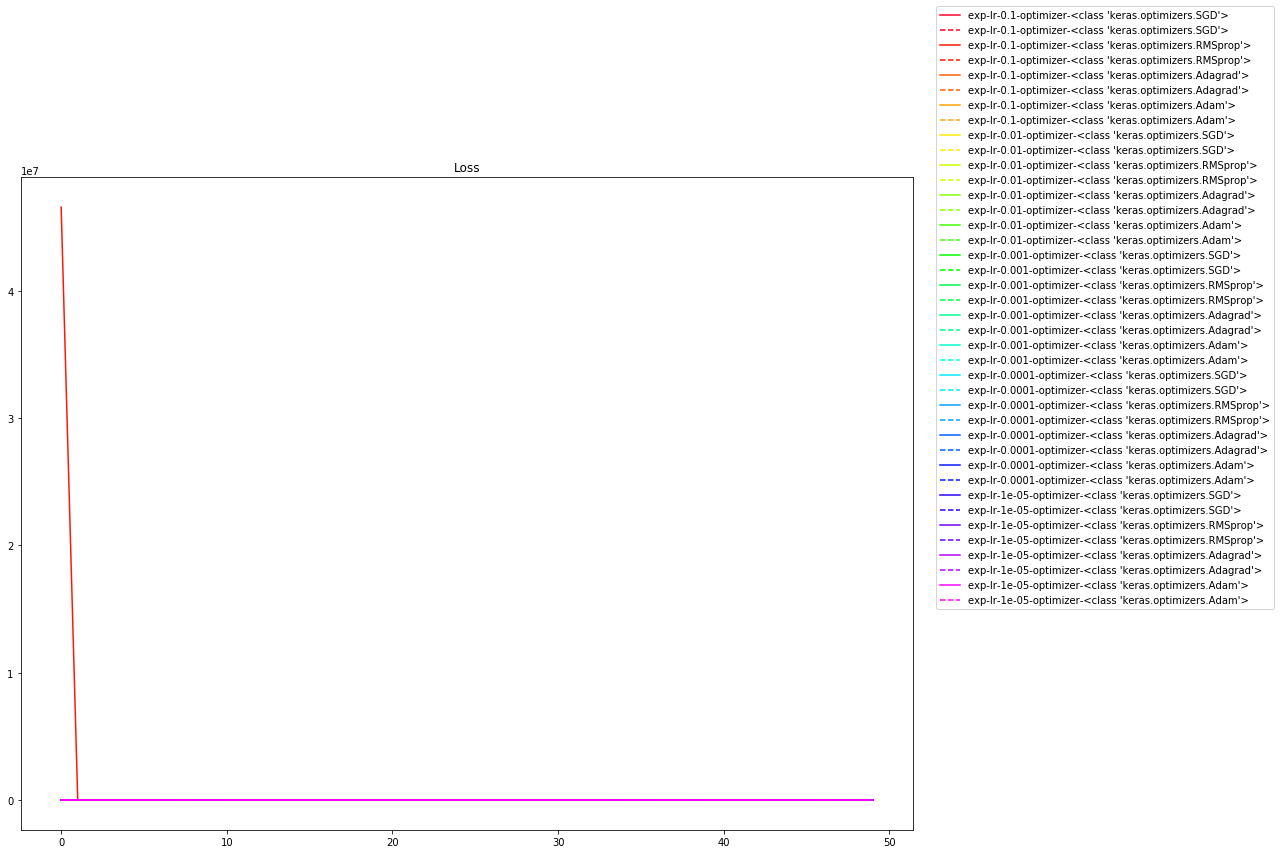

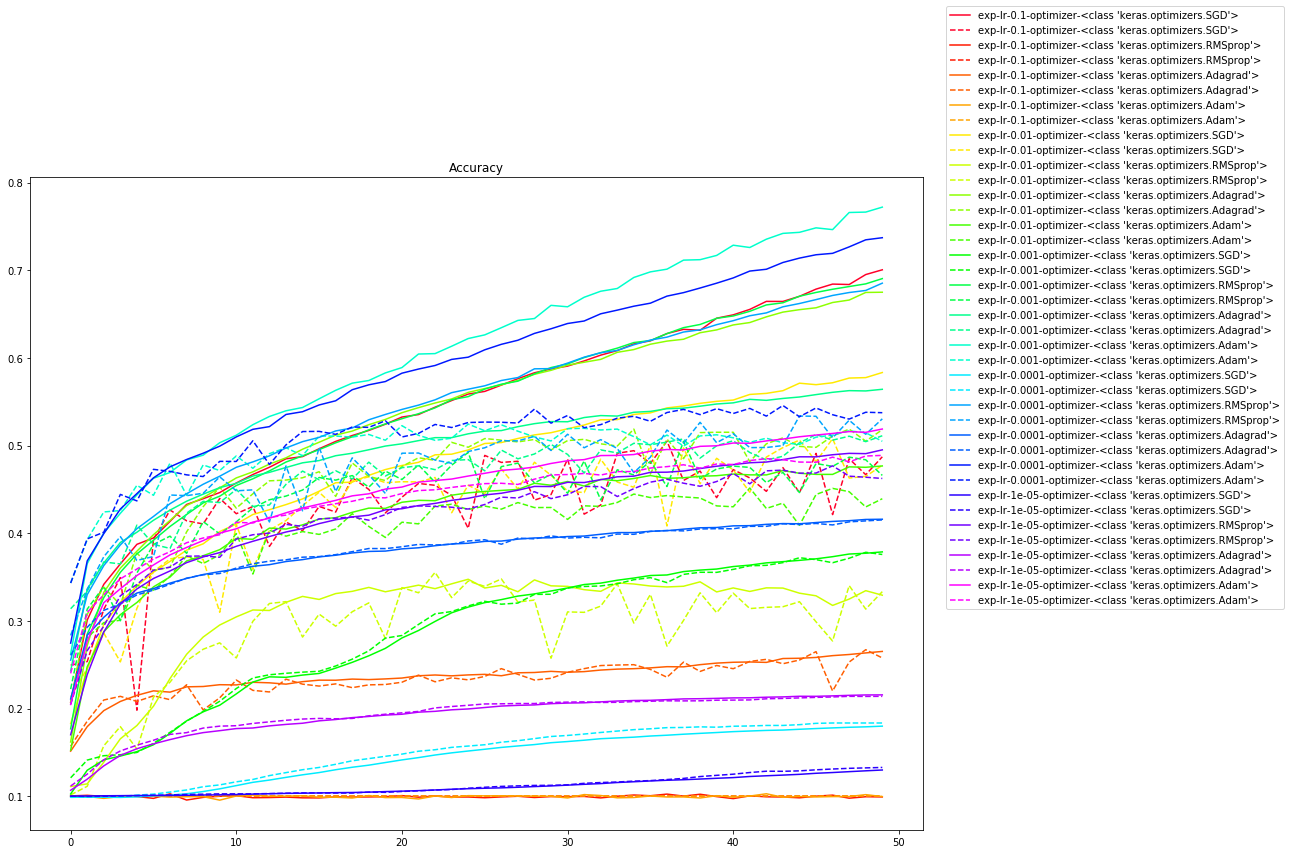

In [9]:
"""
將實驗結果繪出
"""

import matplotlib.pyplot as plt
%matplotlib inline 
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.8))
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.8))
plt.show()
